In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pickle
import time

In [2]:
tf.test.is_gpu_available()

True

In [3]:
with open('mnist-hw1.pkl', 'rb') as f:
    x = pickle.load(f)

In [4]:
def show_images(images, nrof_columns):
    batch, width, height, depth = images.shape
    nrof_rows = int(np.ceil(batch/nrof_columns)) 
    out = np.zeros((nrof_rows*height, nrof_columns*width, depth))
    for i in range(batch):
        x = i % nrof_columns
        y = i // nrof_columns
        out[y*height:(y+1)*height,x*width:(x+1)*width,:] = images[i,:,:,:]
    out[0::height,:,:] = 1.0
    out[:,0::width,:] = 1.0
    out[1::height,:,:] = 1.0
    out[:,1::width,:] = 1.0
    plt.imshow(out)

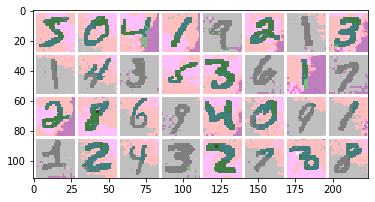

In [5]:
plt.figure()
show_images((x['train'][:32,:,:,:]+1)/4, nrof_columns=8)

In [6]:
def get_mask(kernel_size, channels_in, channels_out, input_channels, mask_type, factorized=True):
    mask = np.zeros(shape=(kernel_size, kernel_size, channels_in, channels_out), dtype=np.float32)
    mask[:kernel_size//2, :, :, :] = 1
    mask[kernel_size//2, :kernel_size//2, :, :] = 1
    
    if factorized:
        if mask_type=='B':
            mask[kernel_size//2, kernel_size//2, :, :] = 1
    else:
        factor_w = int(np.ceil(channels_out/input_channels))
        factor_h = int(np.ceil(channels_in/input_channels))
        k = mask_type=='A'
        m0 = np.triu(np.ones(dtype=np.float32, shape=(input_channels,input_channels)), k)
        m1 = np.repeat(m0, factor_w, axis=1)
        m2 = np.repeat(m1, factor_h, axis=0)
        mask_ch = m2[:channels_in,:channels_out]
        mask[kernel_size//2, kernel_size//2, :, :] = mask_ch
        
    return mask

def masked_conv2d(x, channels_out, kernel_size, input_channels, mask_type, factorized):
    # Get dimensions of the input tensor
    _, h, w, channels_in = x.shape.as_list()
    # Create weight and bias variables
    weights = tf.get_variable('weight', shape=(kernel_size, kernel_size, channels_in, channels_out),  trainable=True)
    bias = tf.get_variable('bias', shape=(h, w, channels_out), trainable=True)
    # Create the mask
    mask = get_mask(kernel_size, channels_in, channels_out, input_channels=input_channels, mask_type=mask_type, factorized=factorized)
    # Apply convolution
    y = tf.nn.conv2d(x, weights*mask, strides=[1, 1, 1, 1], padding='SAME') + bias
    return y
    
def res_block_with_bug(x, channels_out=128, input_channels=None, factorized=True):
    y = tf.nn.relu(x)
    # Downsample channels using 1x1 convolution
    with tf.variable_scope('downsample'):
        y = masked_conv2d(x, channels_out=channels_out, kernel_size=1, input_channels=input_channels, mask_type='B', factorized=factorized)
    y = tf.nn.relu(x)
    # Main convolution
    with tf.variable_scope('conv'):
        y = masked_conv2d(x, channels_out=channels_out, kernel_size=3, input_channels=input_channels, mask_type='B', factorized=factorized)
    y = tf.nn.relu(x)
    # Upsample channels by two using 1x1 convolution
    with tf.variable_scope('upsample'):
        y = masked_conv2d(x, channels_out=channels_out*2, kernel_size=1, input_channels=input_channels, mask_type='B', factorized=factorized)
    return y + x

def res_block(x_in, channels_out=128, input_channels=None, factorized=True):
    x = tf.nn.relu(x_in)
    # Downsample channels using 1x1 convolution
    with tf.variable_scope('downsample'):
        x = masked_conv2d(x, channels_out=channels_out, kernel_size=1, input_channels=input_channels, mask_type='B', factorized=factorized)
    x = tf.nn.relu(x)
    # Main convolution
    with tf.variable_scope('conv'):
        x = masked_conv2d(x, channels_out=channels_out, kernel_size=3, input_channels=input_channels, mask_type='B', factorized=factorized)
    x = tf.nn.relu(x)
    # Upsample channels by two using 1x1 convolution
    with tf.variable_scope('upsample'):
        x = masked_conv2d(x, channels_out=channels_out*2, kernel_size=1, input_channels=input_channels, mask_type='B', factorized=factorized)
    return x + x_in

def pixel_cnn(x, channels_out, factorized):
    input_channels = x.shape.as_list()[3]
    inp = tf.cast(x, tf.int32)
    x = tf.cast(x, tf.float32)
    with tf.variable_scope('input_conv'):
        x = masked_conv2d(x, channels_out=128*2, kernel_size=7, input_channels=input_channels, mask_type='A', factorized=factorized)
    for i in range(12):
        with tf.variable_scope('res_block_%d' % i):
            x = res_block(x, channels_out=128, input_channels=input_channels, factorized=factorized)
    with tf.variable_scope('output_conv_1'):
        x = tf.nn.relu(x)
        x = masked_conv2d(x, channels_out=128, kernel_size=1, input_channels=input_channels, mask_type='B', factorized=factorized)
    with tf.variable_scope('output_conv_2'):
        x = tf.nn.relu(x)
        x = masked_conv2d(x, channels_out=channels_out, kernel_size=1, input_channels=input_channels, mask_type='B', factorized=factorized)
    
    x_rshp = tf.reshape(x, [-1, 28, 28, 3, 4])
    losses = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=inp, logits=x_rshp)
    loss = tf.reduce_mean(losses) * np.log2(np.e)
    probs = tf.nn.softmax(x_rshp)
    return loss, probs, x

In [7]:
def create_dataset(x, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices(x)
    dataset = dataset.repeat()   # Repeat the dataset indefinitely
    dataset = dataset.shuffle(10000)   # Shuffle the data
    dataset = dataset.batch(batch_size)  # Create batches of data
    dataset = dataset.prefetch(batch_size)  # Prefetch data for faster consumption
    iterator = tf.compat.v1.data.make_initializable_iterator(dataset)  # Create an iterator over the dataset
    return iterator

In [8]:
# Train a Pixel-CNN with factorized color representation

nrof_epochs = 5
batch_size = 128
factorized = True

tf.reset_default_graph()
with tf.Graph().as_default():

    train_iterator = create_dataset(x['train'], batch_size)
    test_iterator = create_dataset(x['test'], batch_size)
    eval_input_ph = tf.placeholder(tf.float32, shape=(None, 28, 28, 3))
    
    with tf.compat.v1.variable_scope('model', reuse=False):
        train_loss, _, _ = pixel_cnn(train_iterator.get_next(), channels_out=3*4, factorized=factorized)
    with tf.compat.v1.variable_scope('model', reuse=True):
        test_loss, _, _ = pixel_cnn(test_iterator.get_next(), channels_out=3*4, factorized=factorized)
        eval_loss, eval_probs, _ = pixel_cnn(eval_input_ph, channels_out=3*4, factorized=factorized)
        
    optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
    tvars = tf.trainable_variables()
    grads, _ = tf.clip_by_global_norm(tf.gradients(train_loss, tvars), 1.0)
    train_op = optimizer.apply_gradients(zip(grads, tvars))

    sess  = tf.compat.v1.InteractiveSession()
    sess.run(tf.compat.v1.global_variables_initializer())
    sess.run(train_iterator.initializer)
    sess.run(test_iterator.initializer)

    nrof_train_batches = x['train'].shape[0] // batch_size

    train_loss_list = []
    for epoch in range(1, nrof_epochs+1):
        for i in range(nrof_train_batches):
            _, loss_ = sess.run([train_op, train_loss])
            train_loss_list += [ loss_ ]
            if i % 25 == 0:
                print('train epoch: %4d  batch: %4d  loss: %7.3f' % (epoch, i, loss_))

    test_loss_list = []
    for i in range(x['test'].shape[0] // batch_size):
        loss_ = sess.run([test_loss])
        test_loss_list += [ loss_ ]
    print('test epoch: %d  loss: %.3f' % (epoch, np.mean(test_loss_list)))

W0929 21:50:29.177371 140625343207232 deprecation.py:506] From /home/david/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0929 21:50:30.219345 140625343207232 deprecation.py:323] From /home/david/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/clip_ops.py:286: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


train epoch:    1  batch:    0  loss:   2.272
train epoch:    1  batch:   25  loss:   0.782
train epoch:    1  batch:   50  loss:   0.577
train epoch:    1  batch:   75  loss:   0.512
train epoch:    1  batch:  100  loss:   0.494
train epoch:    1  batch:  125  loss:   0.400
train epoch:    1  batch:  150  loss:   0.378
train epoch:    1  batch:  175  loss:   0.374
train epoch:    1  batch:  200  loss:   0.346
train epoch:    1  batch:  225  loss:   0.362
train epoch:    1  batch:  250  loss:   0.352
train epoch:    1  batch:  275  loss:   0.334
train epoch:    1  batch:  300  loss:   0.383
train epoch:    1  batch:  325  loss:   0.315
train epoch:    1  batch:  350  loss:   0.302
train epoch:    1  batch:  375  loss:   0.303
train epoch:    1  batch:  400  loss:   0.291
train epoch:    1  batch:  425  loss:   0.315
train epoch:    1  batch:  450  loss:   0.275
train epoch:    2  batch:    0  loss:   0.268
train epoch:    2  batch:   25  loss:   0.269
train epoch:    2  batch:   50  lo

In [9]:
def sample(nrof_images, noise=None):
    img = np.zeros((nrof_images, 28, 28, 3), dtype=np.uint8)
    img[:, 0, 0, 0] = np.random.choice(4, size=(nrof_images,))
    for j in range(28):
        for k in range(28):
            for l in range(3):
                loss, p = sess.run([eval_loss, eval_probs], feed_dict={eval_input_ph:img})
                for i in range(nrof_images):
                    img[i, j, k, l] = np.random.choice(4, p=p[i, j, k, l])
    return img

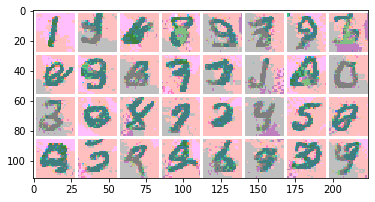

In [10]:
np.random.seed(42)
images = sample(32)
plt.figure()
show_images((images+1)/4, nrof_columns=8)

In [11]:
def dense_masked(x, nrof_units, mask, activation=None):
    nrof_inputs = x.get_shape()[1]
    kernel = tf.get_variable('kernel', shape=(nrof_inputs, nrof_units), dtype=tf.float32, 
        initializer=tf.initializers.glorot_normal, trainable=True)
    bias = tf.get_variable('bias', shape=(nrof_units,), dtype=tf.float32, 
        initializer=tf.initializers.zeros, trainable=True)
    y = tf.tensordot(x, kernel*mask, 1) + bias
    y = activation(y) if activation else y
    return y
    
def get_masks(nrof_units, nrof_layers, nrof_dims, nrof_aux, nrof_bins):
        
    m = []
    m0 = np.repeat(np.arange(nrof_dims), nrof_bins)
    m += [ m0 ]
    for i in range(nrof_layers):
        rep = int(np.ceil(nrof_units/((nrof_dims-1))))
        mx = np.repeat(np.arange(nrof_dims-1), rep)[:nrof_units]
        m += [ mx ]
        
    mask = []
    for i in range(len(m)-1):
        msk = m[i+1][:,None] >= m[i][None,:]
        cx = np.ones((msk.shape[0], nrof_aux))
        msk2 = np.concatenate((cx, msk), axis=1)
        mask += [ msk2.T ]
    msk = m0[:,None] > m[-1][None,:]
    cx = np.ones((msk.shape[0], nrof_aux))
    msk2 = np.concatenate((cx, msk), axis=1)
    mask += [ msk2.T ]
        
    return mask

def made(x, aux, nrof_units, nrof_layers, nrof_dims, nrof_aux, nrof_bins):
    x = tf.cast(x, tf.float32)
    masks = get_masks(nrof_units, nrof_layers, nrof_dims, nrof_aux, nrof_bins)
    hidden = [nrof_units]*nrof_layers+[nrof_dims*nrof_bins]
    for i, h in enumerate(hidden):
        with tf.compat.v1.variable_scope('made_%d' % i):
            activation = tf.nn.relu if i<nrof_layers else None
            xc = tf.concat([aux, x], -1)
            x = dense_masked(xc, h, masks[i], activation=activation)
    return x

In [12]:
def pixel_cnn_made(x_batch):
    dbg = dict()
    _, probs, aux = pixel_cnn(x_batch, channels_out=3*4, factorized=True)
    dbg['pcnn_probs'] = probs
    dbg['pcnn_aux'] = aux
    x_made = tf.reshape(tf.one_hot(x_batch, depth=4), (-1, 3*4))
    dbg['x_made'] = x_made
    aux_rshp = tf.reshape(aux, (-1, 3*4))
    y_made = made(x_made, aux_rshp, nrof_units=128, nrof_layers=2, nrof_dims=3, nrof_aux=3*4, nrof_bins=4)
    y_made_rshp = tf.reshape(y_made, (-1, 28, 28, 3, 4))
    dbg['y_made_rshp'] = y_made_rshp
    probs = tf.nn.softmax(y_made_rshp)
    dbg['made_probs'] = probs
    losses = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=tf.cast(x_batch, tf.int32), logits=y_made_rshp)
    dbg['losses'] = losses
    loss = tf.reduce_mean(losses) * np.log2(np.e)
    return loss, probs, dbg

In [13]:
# Train the full Pixel-CNN-MADE

batch_size = 128
learning_rate = 0.001
nrof_epochs = 15

tf.reset_default_graph()
with tf.Graph().as_default():

    train_iterator = create_dataset(x['train'], batch_size)
    test_iterator = create_dataset(x['test'], batch_size)
    eval_input_ph = tf.placeholder(tf.uint8, shape=(None, 28, 28, 3))
    
    with tf.compat.v1.variable_scope('model', reuse=False):
        train_loss, _, _ = pixel_cnn_made(train_iterator.get_next())
        
    with tf.compat.v1.variable_scope('model', reuse=True):
        test_loss, _, _ = pixel_cnn_made(test_iterator.get_next())
        eval_loss, eval_probs, dbg = pixel_cnn_made(eval_input_ph)
        
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    tvars = tf.trainable_variables()
    grads, _ = tf.clip_by_global_norm(tf.gradients(train_loss, tvars), 0.1)
    train_op = optimizer.apply_gradients(zip(grads, tvars))

    sess  = tf.compat.v1.InteractiveSession()
    sess.run(tf.compat.v1.global_variables_initializer())
    sess.run(train_iterator.initializer)
    sess.run(test_iterator.initializer)

    nrof_train_batches = x['train'].shape[0] // batch_size

    train_loss_list = []
    for epoch in range(1, nrof_epochs+1):
        for i in range(nrof_train_batches):
            _, loss_ = sess.run([train_op, train_loss])
            train_loss_list += [ loss_ ]
            if i % 25 == 0:
                print('train epoch: %4d  batch: %4d  loss: %7.3f' % (epoch, i, loss_))

    test_loss_list = []
    for i in range(x['test'].shape[0] // batch_size):
        loss_ = sess.run([test_loss])
        test_loss_list += [ loss_ ]
    print('test epoch: %d  loss: %.3f' % (epoch, np.mean(test_loss_list)))

/home/david/anaconda3/lib/python3.7/site-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


train epoch:    1  batch:    0  loss:   1.982
train epoch:    1  batch:   25  loss:   0.882
train epoch:    1  batch:   50  loss:   0.614
train epoch:    1  batch:   75  loss:   0.539
train epoch:    1  batch:  100  loss:   0.450
train epoch:    1  batch:  125  loss:   0.439
train epoch:    1  batch:  150  loss:   0.350
train epoch:    1  batch:  175  loss:   0.325
train epoch:    1  batch:  200  loss:   0.301
train epoch:    1  batch:  225  loss:   0.285
train epoch:    1  batch:  250  loss:   0.288
train epoch:    1  batch:  275  loss:   0.262
train epoch:    1  batch:  300  loss:   0.264
train epoch:    1  batch:  325  loss:   0.246
train epoch:    1  batch:  350  loss:   0.234
train epoch:    1  batch:  375  loss:   0.243
train epoch:    1  batch:  400  loss:   0.228
train epoch:    1  batch:  425  loss:   0.224
train epoch:    1  batch:  450  loss:   0.196
train epoch:    2  batch:    0  loss:   0.207
train epoch:    2  batch:   25  loss:   0.191
train epoch:    2  batch:   50  lo

train epoch:   10  batch:  200  loss:   0.048
train epoch:   10  batch:  225  loss:   0.049
train epoch:   10  batch:  250  loss:   0.049
train epoch:   10  batch:  275  loss:   0.048
train epoch:   10  batch:  300  loss:   0.047
train epoch:   10  batch:  325  loss:   0.048
train epoch:   10  batch:  350  loss:   0.047
train epoch:   10  batch:  375  loss:   0.048
train epoch:   10  batch:  400  loss:   0.047
train epoch:   10  batch:  425  loss:   0.047
train epoch:   10  batch:  450  loss:   0.049
train epoch:   11  batch:    0  loss:   0.048
train epoch:   11  batch:   25  loss:   0.046
train epoch:   11  batch:   50  loss:   0.048
train epoch:   11  batch:   75  loss:   0.048
train epoch:   11  batch:  100  loss:   0.047
train epoch:   11  batch:  125  loss:   0.047
train epoch:   11  batch:  150  loss:   0.047
train epoch:   11  batch:  175  loss:   0.047
train epoch:   11  batch:  200  loss:   0.047
train epoch:   11  batch:  225  loss:   0.047
train epoch:   11  batch:  250  lo

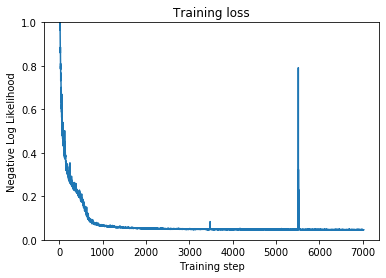

In [14]:
plt.plot(train_loss_list)
plt.ylim((0.0,1.0))
plt.title('Training loss')
plt.xlabel('Training step')
_ = plt.ylabel('Negative Log Likelihood')

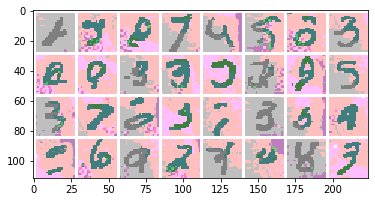

In [15]:
np.random.seed(42)
images = sample(32)
plt.figure()
show_images((images+1)/4, nrof_columns=8)